# Leveraging Social Media in Stock Prediction

## Introduction
Predicting stock market performance is big business. However, most models are incomplete as they have been unable to take social influence into account. Mining social media for insight into the sentiment of stock traders and investors has the potential to lead to a more-complete understanding of stocks performance. 

[StockTwits](http://stocktwits.com/) is a social-media platform similar to Twitter aimed at stock traders and investors. Instead of hashtags, StockTwits has stock ticker tags like **\$AMD** or **\$AAPL** that users post in their twits. In addition, tweets can be tagged with 'bullish' or 'bearish' to indicate if the poster thinks the mentioned stocks will move upwards or downwards in price. 

We will conduct several analyses using this data:
* Use bullish/bearish tagged tweets to train a classifier to gauge sentiment based on tweet text.
* Visualize metrics from both StockTwits and the Stock Market to gain intuition on their relationship. 
* Implement sentiment analysis on specific companies, and see if trending companies and bullish/bearish tags correlate with the movement of the actual stock price or trading volume. 

Ultimately, our team will focus on combining data from StockTwits with actual stock data to gain interesting insights into the stock market.

## Progress
Work has begun mining StockTweets and processing tweets to predict the authors' sentiments. A baseline sentiment predictor has been completed using TF-IDF features and a linear SVM.

Mining data is by far the most time-dependent process. As we build a larger library of tweets, we will better be able to visualize and understand the relationship between market sentiment and stock performance. 

## Prior Work
StockTwits provides [several whitepapers](http://stocktwits.com/developers/docs/research) on previous experiments conducted using their service. In particular, *[On the Predictability of Stock Market Behavior
using StockTwits Sentiment and Posting Volume](http://stocktwits.com/research/Predictability-of-stock-market-behavior-using-stocktwits-sentiment-and-posting-volume_NunoOliveira.pdf)* appears to be a useful template for this project.

* **Note:** If you don't have `pandas_datareader` installed, uncomment the line below to install it

In [2]:
#!pip install pandas_datareader

In [3]:
#from nltk.tokenize import word_tokenize
import io, json, requests, time, os, os.path, math, urllib
from sys import stdout
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn import linear_model
from pandas_datareader.data import get_data_yahoo
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## StockTwits Data Collection
Frst we will write a function to query the StockTwits API to get up to 30 tweets at a time for a given ticker symbol. The API allows getting only tweets older than some tweet ID, which we need for repeatedly querying the server to get many recent tweets.

In [4]:
# returns python object representation of JSON in response
def get_response(symbol, older_than, retries=5):
    url = 'https://api.stocktwits.com/api/2/streams/symbol/%s.json?max=%d' % (symbol, older_than-1)
    for _ in range(retries):
        response = requests.get(url)
        if response.status_code == 200:
            return json.loads(response.content)
        elif response.status_code == 429:
            print response.content
            return None
        time.sleep(1.0)
    # couldn't get response
    return None

Now we can write a function to build or extend a dataset of tweets for a given symbol. This works by remembering the oldest ID of tweets we have gotten so far, and using that as an option in the API query to get older tweets. By doing this we can iteratively build up a list of recent tweets for a given symbol ordered from most recent to least. The data is stored in JSON form, which is the same format the API returns to us.

In [5]:
# extends the current dataset for a given symbol with more tweets
def get_older_tweets(symbol, num_queries):    
    path = './data/%s.json' % symbol
    if os.path.exists(path):
        # extending an existing json file
        with open(path, 'r') as f:
            data = json.load(f)
            if len(data) > 0:
                older_than = data[-1]['id']
            else:
                older_than = 1000000000000
    else:
        # creating a new json file
        data = []
        older_than = 1000000000000 # any huge number
    
    for i in range(num_queries):
        content = get_response(symbol, older_than)
        if content == None:
            print 'Error, an API query timed out'
            break
        data.extend(content['messages'])
        older_than = data[-1]['id']
        stdout.write('\rSuccessfully made query %d' % (i+1))
        stdout.flush()
        # sleep to make sure we don't get throttled
        time.sleep(0.5)
        
    # write the new data to the JSON file
    with open(path, 'w') as f:
        json.dump(data, f)
    print
    print 'Done'

Now we fetch data for several ticker symbols. Note that to get all the data, you will have to rerun this cell once an hour multiple times because of API rate limiting. The JSON files will be distributed with this notebook so this cell is only here to show how we originally got the data.

In [6]:
# get some data
# apparently a client can only make 200 requests an hour, so we can't get all the data at once

# make data directory if needed
if not os.path.exists('./data'):
    os.mkdir('./data')
    
symbols = symbols = ['AAPL', 'NVDA', 'TSLA', 'AMD', 'JNUG', 'JDST', 'LABU', 'QCOM', 'INTC', 'DGAZ']
tweets_per_symbol = 3000
for symbol in symbols:
    path = './data/%s.json' % symbol
    if os.path.exists(path):
        with open(path, 'r') as f:
            num_tweets = len(json.load(f))
    else:
        num_tweets = 0
    num_queries = (tweets_per_symbol - num_tweets - 1)/30 + 1
    if num_queries > 0:
        print 'Getting tweets for symbol %s' % symbol
        get_older_tweets(symbol, num_queries)

Getting tweets for symbol INTC
Successfully made query 100
Done
Getting tweets for symbol DGAZ
Successfully made query 100
Done


The next cell is mainly just for debugging purposes. There is no need to run it.

In [7]:
# check that we're doing the querying and appending correctly without getting duplicates
# and that message IDs are in descending order
symbol = 'NVDA'
with open('./data/%s.json' % symbol, 'r') as f:
    data = json.load(f)
S = set()
old_id = 1000000000000
for message in data:
    message_id = message['id']
    assert message_id not in S
    assert message_id < old_id
    old_id = message_id
    S.add(message_id)
print 'Passed'

Passed


# Stock Market Data Comparison

Next, we'll extract stock market data for the symbols we're interested in. Pandas provides an inteface to do this through Yahoo Finance. 

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,111.389999,111.440002,107.349998,109.330002,53204600,105.158716
2015-01-05,108.290001,108.650002,105.410004,106.250000,64285500,102.196226
2015-01-06,106.540001,107.430000,104.629997,106.260002,65797100,102.205846
2015-01-07,107.199997,108.199997,106.699997,107.750000,40105900,103.638996
2015-01-08,109.230003,112.150002,108.699997,111.889999,59364500,107.621041


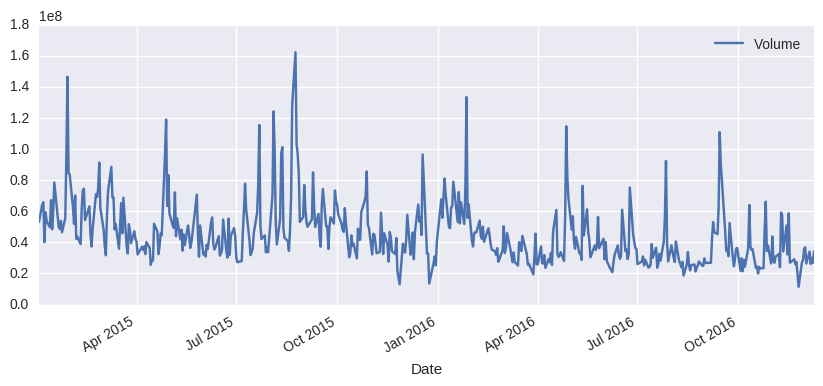

In [8]:
enddate=datetime.now()
startdate=datetime(2015,1,1)
stock_data = get_data_yahoo('AAPL',startdate,enddate)
stock_data['Volume'].plot(legend=True,figsize=(10,4));
stock_data.head()

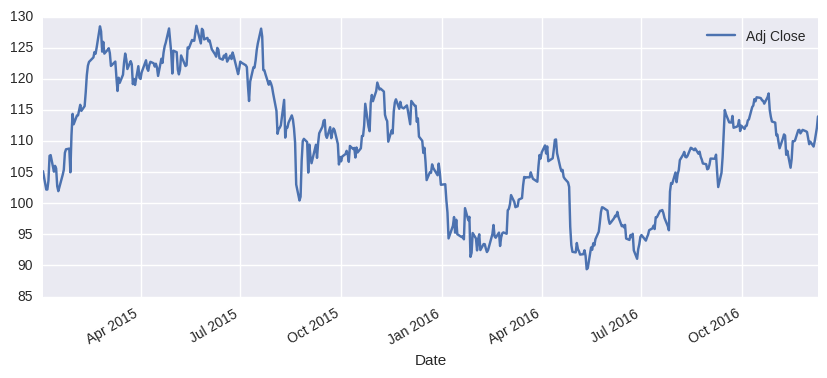

In [9]:
stock_data['Adj Close'].plot(legend=True,figsize=(10,4));

As you can see, we can quickly and easily pull both volume and closing prices for the dates of interest. 

Next, we will parse the JSON data we've collected into a Pandas DataFrame to more easily work with it.

In [10]:
# Function takes in a JSON and returns a Pandas DataFrame for easier operation. 
def stocktwits_json_to_df(data, verbose=False):
    #data = json.loads(results)
    columns = ['id','created_at','username','name','user_id','body','basic_sentiment','reshare_count']
    db = pd.DataFrame(index=range(len(data)),columns=columns)
    for i, message in enumerate(data):
        db.loc[i,'id'] = message['id']
        db.loc[i,'created_at'] = message['created_at']
        db.loc[i,'username'] = message['user']['username']
        db.loc[i,'name'] = message['user']['name']
        db.loc[i,'user_id'] = message['user']['id']
        db.loc[i,'body'] = message['body']
        
        #We'll classify bullish as +1 and bearish as -1 to make it ready for classification training
        try:
            if (message['entities']['sentiment']['basic'] == 'Bullish'):
                db.loc[i,'basic_sentiment'] = 1
            elif (message['entities']['sentiment']['basic'] == 'Bearish'):
                db.loc[i,'basic_sentiment'] = -1
            else:
                db.loc[i,'basic_sentiment'] = 0
        except:
                db.loc[i,'basic_sentiment'] = 0
                
        db.loc[i,'reshare_count'] = message['reshares']['reshared_count']

        for j, symbol in enumerate(message['symbols']):
                db.loc[i,'symbol'+str(j)] = symbol['symbol']
            
        if verbose:
            #print message
            print db.loc[i,:]
    db['created_at'] = pd.to_datetime(db['created_at'])
    return db

We're going to use **\$LABU** to visualize data since we have data going back the furthest. We'll now combine these two data sources, so we can generate useful metrics for understanding how StockTwits relates to the stock market over time.

In [11]:
# Load tweets for visualizing data
filename = 'TSLA.json'
path = './tsla_data/%s' % filename
with open(path, 'r') as f:
    data = json.load(f)
db = stocktwits_json_to_df(data)
print '%d examples extracted ' % db.shape[0]

14998 examples extracted 


In [12]:
enddate = db['created_at'].max()
startdate = db['created_at'].min()
print startdate, enddate
stock_data = get_data_yahoo('TSLA', startdate, enddate)

2016-10-17 17:25:28 2016-11-19 22:43:16


In [13]:
#Counts mentions and bullish/bearish ratio of stock tweets collected
def tweet_metrics(stock_data, stock_tweets):
    stock_data['mentions'] = np.zeros(stock_data.shape[0])
    stock_data['total_bullish'] = np.zeros(stock_data.shape[0])
    stock_data['total_bearish'] = np.zeros(stock_data.shape[0])
    stock_data['total_predictions'] = np.zeros(stock_data.shape[0])
    stock_data['bull_ratio'] = np.zeros(stock_data.shape[0])
    stock_data['bear_ratio'] = np.zeros(stock_data.shape[0])
    for i, d in enumerate(stock_data.index):
        tweets_on_d = stock_tweets[stock_tweets['created_at'].dt.date==d.date()]
        stock_data.loc[d,'mentions'] = tweets_on_d.shape[0]
        stock_data.loc[d,'total_bullish'] = tweets_on_d[tweets_on_d['basic_sentiment']==1].shape[0]
        stock_data.loc[d,'total_bearish'] = tweets_on_d[tweets_on_d['basic_sentiment']==-1].shape[0]
        stock_data.loc[d,'total_predictions'] =  stock_data.loc[d,'total_bearish'] +  stock_data.loc[d,'total_bullish']
        stock_data.loc[d,'bull_ratio'] = stock_data.loc[d,'total_bullish']/float(stock_data.loc[d,'total_predictions'])
        stock_data.loc[d,'bear_ratio'] = stock_data.loc[d,'total_bearish']/float(stock_data.loc[d,'total_predictions'])
    return stock_data

In [14]:
stock_metrics = tweet_metrics(stock_data, db)
print stock_metrics[['mentions','total_bullish','total_bearish','bull_ratio']]

            mentions  total_bullish  total_bearish  bull_ratio
Date                                                          
2016-10-17     113.0           16.0            9.0    0.640000
2016-10-18     564.0          102.0           61.0    0.625767
2016-10-19    1308.0          353.0           65.0    0.844498
2016-10-20    1417.0          293.0          139.0    0.678241
2016-10-21     236.0           49.0           26.0    0.653333
2016-10-24     220.0           56.0           14.0    0.800000
2016-10-25     195.0           38.0            8.0    0.826087
2016-10-26    1973.0          411.0          135.0    0.752747
2016-10-27    1427.0          228.0          166.0    0.578680
2016-10-28     295.0           37.0           29.0    0.560606
2016-10-31     313.0           52.0           31.0    0.626506
2016-11-01     905.0          100.0          110.0    0.476190
2016-11-02     433.0           58.0           81.0    0.417266
2016-11-03     298.0           31.0           46.0    0

Note that Yahoo's Finance data is "delayed" (i.e. It won't show the current day unless the market has closed.

## Visualization & Data Exploration
Next, we'll compare our metrics to gain an understand of StockTwits's correlation to the stock market. In our first comparison, we see a clear correlation between the number of mentions and the trading volume. 

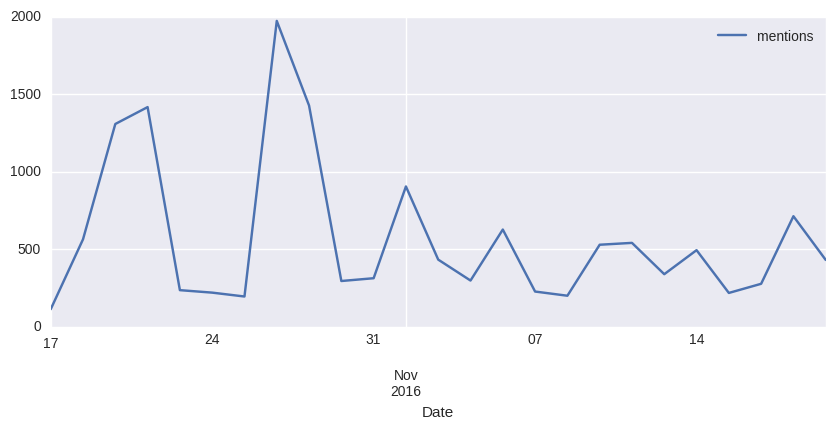

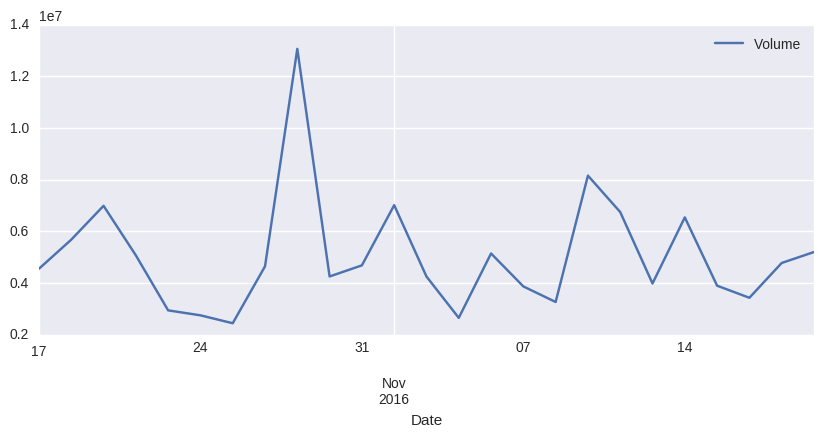

In [15]:
stock_metrics[['mentions']].plot(legend=True,figsize=(10,4));
stock_metrics[['Volume']].plot(legend=True,figsize=(10,4));

Finally, we'll compare the total closing price to the bullish/bearish predictions of Stock Twits. Again, there appears to be some strong correlations. 

*Total Predictions* matched the *Closing Price* tightly. Interestingly, it seems that StockTwits' users accurately predicted the rise price collapse. We can see that *Total Bearish* rose sharply on November 9th prior to the stock's tumble on the 10th. As we gather more data, we'll see if this pattern repeats itself. 

In the second plot below, it appears that the ratio of *Bullish* to *Bearish* predictions lags the stocks performance. With one side dominating after the price correction has run its course.

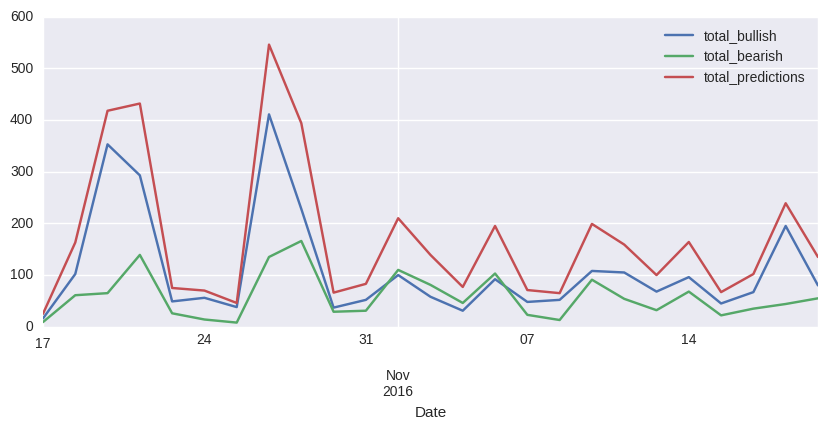

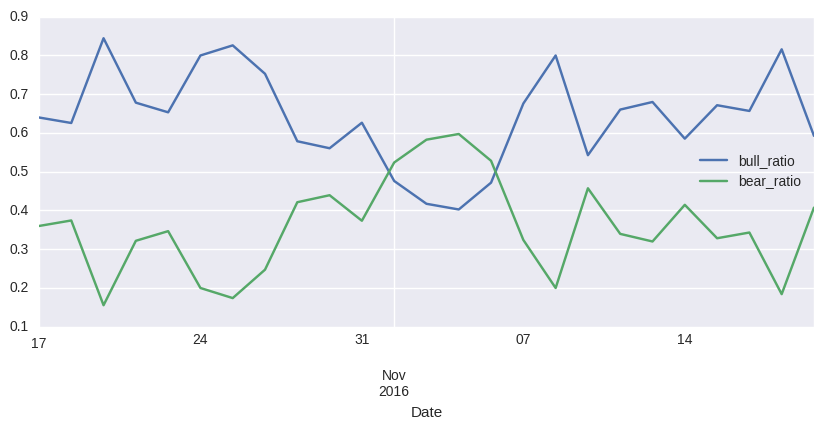

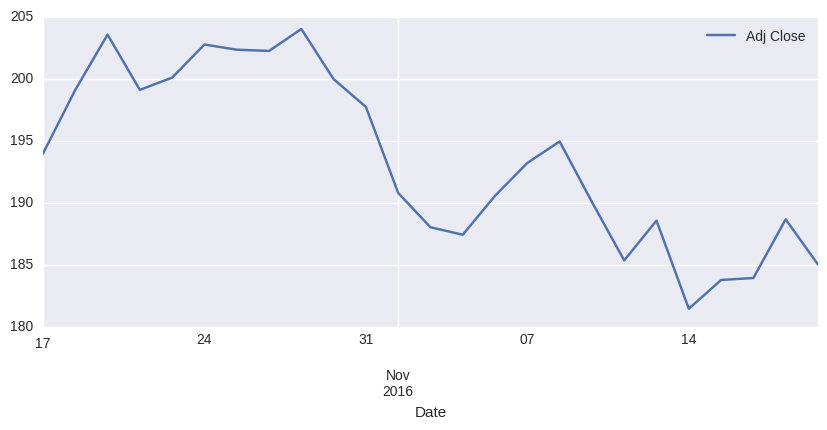

In [16]:
stock_metrics[['total_bullish','total_bearish','total_predictions']].plot(legend=True,figsize=(10,4));
stock_metrics[['bull_ratio','bear_ratio']].plot(legend=True,figsize=(10,4));
stock_metrics[['Adj Close']].plot(legend=True,figsize=(10,4));

In [17]:
def countcomentions(df):
    
    def getsymbolset(df):
        symbols = []
        for i, row in df.iterrows():
            for symbol in row:
                if (pd.notnull(symbol)):
                    symbols.append(symbol)
        return set(symbols)
   
    def getallsymbols(df):
        columns = df.columns
        symbolcolumns = []
        for col in columns:
            if col.startswith('symbol'):
                symbolcolumns.append(col)
        return df[symbolcolumns]
        
    def count(df, stock_symbol):
        cnt = Counter()
        for i, row in df.iterrows():
            for sym in row:
                if (sym!=stock_symbol) & pd.notnull(sym):
                    cnt[sym] += 1
        return cnt
    
    df = getallsymbols(df)
    symbolset = getsymbolset(df)
    print len(symbolset), "total symbols found."
    co = np.zeros((len(symbolset), len(symbolset)))
    co = pd.DataFrame(co, index=symbolset, columns=symbolset)
    for i, row in df.iterrows():
        for stock_symbol in row:
            for sym in row:
                if (sym!=stock_symbol) & pd.notnull(stock_symbol) & pd.notnull(sym):
                    co.loc[stock_symbol,sym]+=1
    return co
    #return pd.DataFrame(co)
    
co = countcomentions(db)

788 total symbols found.


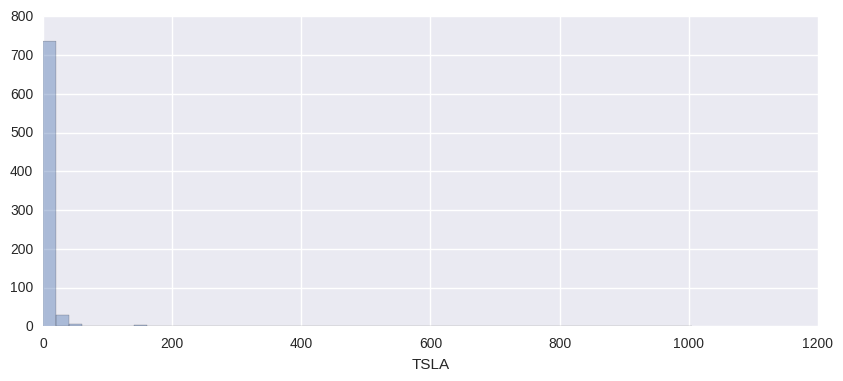

In [18]:
plt.figure(figsize=(10,4))
sns.distplot(co.loc['TSLA',:], kde=False)

In [19]:
co.loc['TSLA',co.loc['TSLA',:]>0].sort_values(ascending=False)[:20]

SCTY     1005.0
AAPL      480.0
AMZN      366.0
NFLX      244.0
SPY       242.0
FB        238.0
GOOGL     173.0
F         157.0
GM        147.0
BABA      146.0
TWTR      146.0
NVDA      120.0
GOOG      111.0
QQQ        90.0
CMG        86.0
TWLO       57.0
GPRO       54.0
BMY        53.0
UAA        52.0
ACIA       45.0
Name: TSLA, dtype: float64

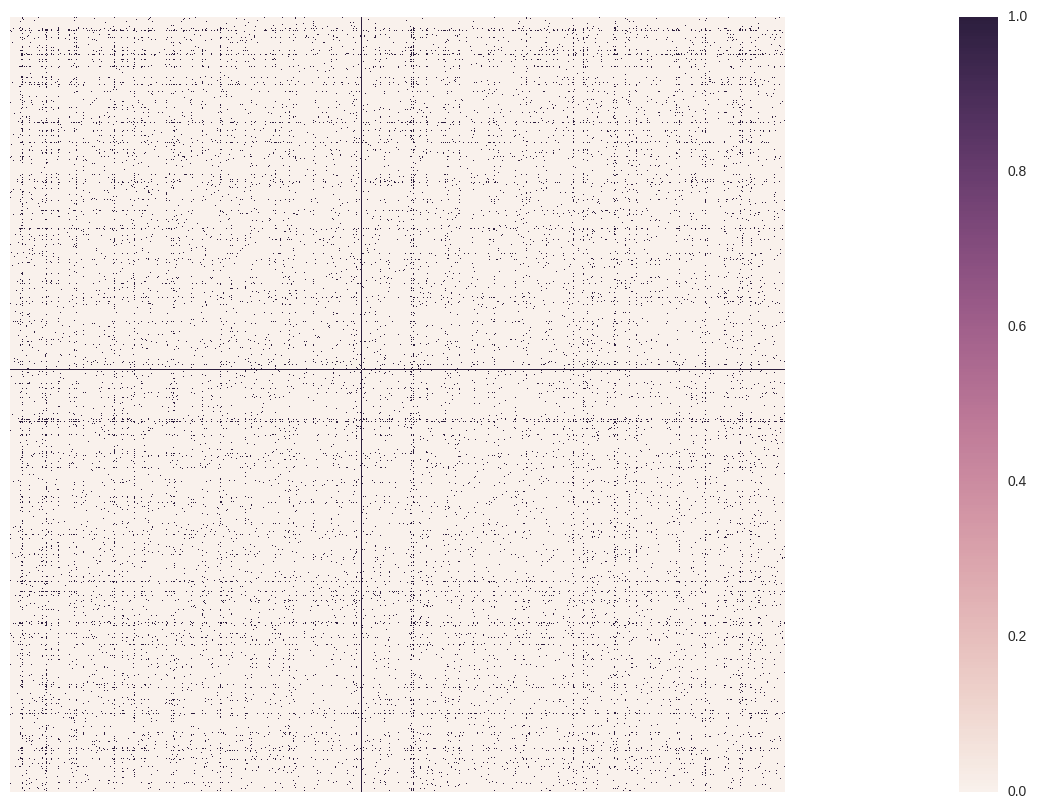

In [20]:
plt.figure(figsize=(45,10))
sns.heatmap(co, xticklabels=False, vmin=0, vmax=1, yticklabels=False, square=True);

# Sentiment Prediction
Some of the tweets have bullish or bearish labels, indicating if the poster thinks the mentioned stock will go up or down in price respectively. We will extract only those tweets which have such sentiment labels, and convert the labels into either 0 for bearish or 1 for bullish.

In [21]:
def get_tweets_and_labels(data):
    # filter out messages without a bullish/bearish tag
    data = filter(lambda m: m['entities']['sentiment'] != None, data)
    # get tweets
    tweets = map(lambda m: m['body'], data)
    # get labels
    def create_label(message):
        sentiment = message['entities']['sentiment']['basic']
        if sentiment == 'Bearish':
            return 0
        elif sentiment == 'Bullish':
            return 1
        else:
            raise Exception('Got unexpected sentiment')
    labels = map(create_label, data)
    return tweets, labels

In [22]:
# get all tweets and labels available
tweets = []
labels = []
all_tweets = []
for filename in os.listdir('./data'):
    path = './data/%s' % filename
    with open(path, 'r') as f:
        data = json.load(f)
    all_tweets.extend(map(lambda m: m['body'], data))
    t, l = get_tweets_and_labels(data)
    tweets.extend(t)
    labels.extend(l)
assert len(tweets) == len(labels)
print '%d labeled examples extracted ' % len(tweets)

15621 labeled examples extracted 


The next two cells make functions to create a TF-IDF vectorizer for the tweets and to train a linear SVM classifier to predict bearish or bullish sentiment.

In [23]:
def tfidf_vectorizer(tweets, all_tweets=None):
    vectorizer = TfidfVectorizer()
    if all_tweets != None:
        # use all tweets, including unlabeled, to learn vocab and tfidf weights
        vectorizer.fit(all_tweets)
    else:
        vectorizer.fit(tweets)
    return vectorizer

In [24]:
def train_svm(X, y):
    model = svm.LinearSVC(penalty='l2', loss='hinge', C=1.0)
    #model = svm.SVC(C=1.0, kernel='rbf')
    model.fit(X, y)
    return model

We first create the TF-IDF feature matrix for all of our labeled data. Then we randomly permute it and split 10% off into a held out test set. We also print out the percentage of labeled tweets that are bullish, because the 2 classes are likely not balanced. We want to know how well a classifier that only predicts the most common class would do.

In [25]:
vectorizer = tfidf_vectorizer(tweets, all_tweets)
X = vectorizer.transform(tweets)
words = vectorizer.get_feature_names()
y = np.array(labels)
print X.shape
print y.shape

N = X.shape[0]
num_train = int(math.floor(N*0.9))
P = np.random.permutation(N)
X_tr = X[P[:num_train]]
y_tr = y[P[:num_train]]
X_te = X[P[num_train:]]
y_te = y[P[num_train:]]
print 'Training set size is %d' % num_train
print 'Percent bullish = %f%%' % (100*y.mean())

(15621, 31315)
(15621,)
Training set size is 14058
Percent bullish = 74.899174%


Now it is simple to train the SVM and print our the accuracy for both the training and testing data.

In [26]:
model = train_svm(X_tr, y_tr)
print 'Training set accuracy = %f' % model.score(X_tr, y_tr)
print 'Test set accuracy = %f' % model.score(X_te, y_te)

Training set accuracy = 0.888249
Test set accuracy = 0.809341


We can see that the classifier does several percent better than just guessing the most common class.
Now that we have a trained SVM, we can use the weights to print out words most indicative of bearish or bullish sentiment. This is because we used a linear SVM, so each weight coefficient corresponds to a column in the TF-IDF matrix, which itself corresponds to a word. We get the indices of the weight coefficients with the highest and lowest values, and use them to print the most bullish and bearish words.

In [27]:
weights = np.squeeze(model.coef_)
sorted_weight_indices = np.argsort(weights)
num_words = 30
bearish_indices = sorted_weight_indices[:num_words]
bullish_indices = sorted_weight_indices[-num_words:][::-1]
words = np.array(words)
print 'Bearish words:'
for w in words[bearish_indices]:
    print w
print
print 'Bullish words:'
for w in words[bullish_indices]:
    print w

Bearish words:
puts
bearish
short
below
terrible
down
scam
breakdown
tank
flush
fake
abandon
debt
raise
180
pie
sucked
slaughter
overvalued
downfall
star
188
185
pig
740
dump
worse
108
biib
excrement

Bullish words:
squeeze
bears
calls
amd
upside
bullish
higher
shorts
bear
want
recover
relax
boss
breakout
future
ugaz
dollar
111
buy
green
release
love
ng
apple
dgaz
shorties
tonight
qcom
long
above


The results are actually pretty interesting. I'll give a bit of explanation for some of the terms for people who are not familiar with the stock market. If you expect the price of a stock to fall, you can try to make money off it by shorting it or buying a type of option called puts. If the price is falling, you could say it is tanking, crashing, or on a downtrend. The classifier picked up on all of these terms, and many more, as correctly indicating bearish sentiment.

Likewise, if you expect the price to rise, you can make money by buying the stock and going 'long' on it, or by buying a type of option known as calls. And obviously terms like 'higher' or 'buy' clearly indicated bullishness. The classifier picked up on all these terms and others that are similar as correctly being indicative of bullish sentiment.

Finally, let's use a trained classifier to predict sentiment on a held-out dataset of Tesla Motors tweets, and plot it along with the actual sentiment. We use logistic regression instead of SVM for this experiment because we find it gives better results.

body                           object
date                   datetime64[ns]
sentiment                     float64
predicted_sentiment             int64
dtype: object
                                                body                date  \
0  $TSLA let&#39;s hope the new product contribut... 2016-10-17 17:25:28   
1  $TSLA \nElon&#39;s new product just leaked: it... 2016-10-17 17:27:25   
2  $TSLA how low can this go with an announcement... 2016-10-17 17:28:01   
3  $TSLA every spike gets stuffed . Lows on deck ... 2016-10-17 17:28:02   
4  $TSLA - lets see if LOD holds. Doubtful, but w... 2016-10-17 17:28:04   

   sentiment  predicted_sentiment  
0        NaN                    1  
1        NaN                    0  
2        NaN                    1  
3        NaN                    0  
4        0.0                    0  
            sentiment  predicted_sentiment
date                                      
2016-10-17   0.640000             0.566372
2016-10-18   0.625767           

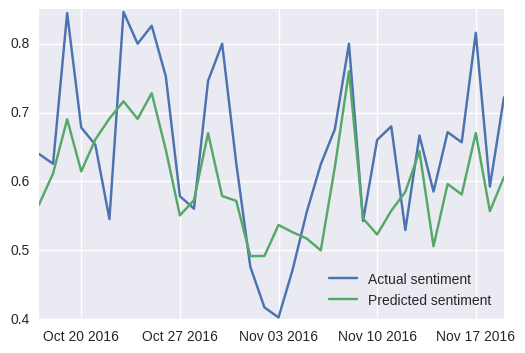

In [28]:
model = linear_model.LogisticRegression(penalty='l2', C=5.0, class_weight='balanced')
#model = svm.LinearSVC(penalty='l2', loss='hinge', C=5.0, class_weight='balanced')
model.fit(X_tr, y_tr)

with open('./tsla_data/TSLA.json', 'r') as f:
    data = json.load(f)[::-1]

def extract_body(m):
    return m['body']

def extract_date(m):
    return m['created_at']

def extract_sentiment(m):
    if m['entities']['sentiment'] != None:
        sentiment = m['entities']['sentiment']['basic']
        if sentiment == 'Bearish':
            return 0
        else:
            return 1
    else:
        return np.nan
    
d = {'body': map(extract_body, data),
     'date': pd.to_datetime(map(extract_date, data)),
     'sentiment': map(extract_sentiment, data)}
df = pd.DataFrame(data=d)

# use classifier to predict sentiment for unlabeled examples
features = vectorizer.transform(df['body'])
predictions = model.predict(features)
predicted_sentiment = []
for i, sentiment in enumerate(df['sentiment']):
    if np.isnan(sentiment):
        predicted_sentiment.append(predictions[i])
    else:
        predicted_sentiment.append(sentiment)
df['predicted_sentiment'] = pd.Series(predictions)

print df.dtypes
print df.head()

grouped_df = df.groupby(pd.Grouper(key='date', freq='1D')).aggregate(np.mean)

print grouped_df.head()

plt.plot(grouped_df['sentiment'], label='Actual sentiment')
plt.plot(grouped_df['predicted_sentiment'], label='Predicted sentiment')
plt.legend(loc='lower right')

coef = np.corrcoef(grouped_df['sentiment'], grouped_df['predicted_sentiment'])[0,1]
print
print 'Correlation coefficient = %f' % coef

To make the plot above we've assigned 0 to bearish and 1 to bullish, and averaged the results for each day. The actual sentiment calculation ignores any unlabeled tweets. The predicted sentiment treats all tweets as unlabeled and uses the classifier to predict 0 or 1. It is clear that while the predicted sentiment does not always exactly match the actual, the trend generally holds. That is, movements in the predicted sentiment often match movements in the actual sentiment, which is reflected in the positive correlation coefficient. This means that even in the absence of explicitly labeled sentiment data, it is possible to use machine learning techniques to get an estimate of investor sentiment based purely on the textual content of tweets.

## Conclusion
It's clear that there is more work to be done. However, we have a strong framework in place. As we collect more data, we will be able to better understand StockTwit's potential to track the stock market. 

Additionally, with the tools implemented above we can focus on improving our stock performance predictions. We're eyeing several algorithms to better predict user sentiment and explore their relation to the market.